In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio import features
from glob import glob
from tqdm import tqdm

In [2]:
# Combining the two into one dataframe
def merge_shp_bnd(shp,bbnd):
    shp = shp.set_index("GEOID10")
    shp.index = shp.index.map(int)
    
    bbnd = bbnd.set_index("FIPS")
    bbnd.index = bbnd.index.map(int)
    return shp.merge(bbnd,left_index=True, right_index=True, how="inner")

def lteraster_from_sat(lte, path):
    with rio.open(path) as dataset:
        
        satimg = dataset.read()
        mask = dataset.dataset_mask()
        sat_trs = dataset.transform
        sat_crs = dataset.crs

        results = (
            {'properties': {'raster_val': v}, 'geometry': s}
            for i, (s, v) 
            in enumerate(
                rio.features.shapes(mask, transform=dataset.transform)))

    sat = gpd.GeoDataFrame.from_features(list(results),crs=sat_crs)
    
    lte = lte.to_crs(sat_crs)
    ovr = gpd.overlay(sat,lte)
    
    shapes = [(geom,value) for geom, value in zip(ovr["geometry"],ovr["4G_LTE"])]
    return features.rasterize(shapes,np.shape(satimg[0]),transform=sat_trs)


In [5]:
%%time
state = "or"
actual477 = pd.read_csv("./fcc477actual/{}_201906.csv".format(state.upper()))
censusblocks = gpd.read_file("./shapefiles/censusblocks/{}/tabblock10.shp".format(state))

Wall time: 14.6 s


In [6]:
%%time
merged = merge_shp_bnd(censusblocks,actual477)

Wall time: 718 ms


In [7]:
open_path = glob("./sentinel2/{}/composite/*.tif".format(state))
save_path = "./fcc477actual/sentinel2/{}/npz/".format(state)

for path in tqdm(open_path):
    sat_id = path.split("\\")[1].split(".")[0]
    lteraster = lteraster_from_sat(merged, path)
    np.savez_compressed(save_path+sat_id,lteraster)

  0%|          | 0/16 [00:00<?, ?it/s]C:\Users\Tyler\anaconda3\envs\cs230\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
  6%|▋         | 1/16 [00:58<14:43, 58.87s/it]C:\Users\Tyler\anaconda3\envs\cs230\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
 12%|█▎        | 2/16 [02:06<14:19, 61.40s/it]C:\Users\Tyler\anaconda3\envs\cs230\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


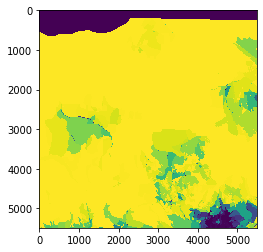

In [8]:
%pylab
%matplotlib inline
imshow(lteraster)